### 概要

* 评价指标,评价方法

* EE问题以及解决方案，代码实现
    * 如果平衡准确性和新颖性
    * 多臂老虎机
    
* 冷启动问题：
    * 本质
    * 冷启动类型与解决方案
    
* 推荐系统架构

### 评价指标,评价方法

* 评价指标：
    * 准确性
    * 满意度
    * 覆盖度
    * 信任度
    * 实时性
    * 鲁棒性
    * 可扩展性
    * 商业目的
    * 用户留存
    * 多样性
    * 新颖性
    * 惊喜度

* 评价方法：
    * 准确性：
        * 评分预测：RMSE,MAE
        * topN推荐：准确率，召回率
    * 覆盖度：
        * 覆盖率 ： $ R(u) \over |I| $
        * 信息熵 :  $ - \sum P(x)logP(x)$  熵越大，推的东西越丰富
        * 基尼系数: $ G = {1 \over {n - 1}} \sum (2j - n- 1)p(i_j) $ 按流行度对商品i排序(次序是j)
        * 流量占比：?

### EE问题以及解决方案

* EE问题
    * Exploitation : 选择选择可能最佳的方案
    * Exploration : 选择现在不确定的一些方案，但是未来可能是高收益的方案
    
在做两类决策的过程中，不断更新对所欲决策的不确定性的认知，优化长期目标函数

* Bandit 算法：
    * Epsilon-Greedy : 以 1-epsilon 的概率选取当前收益的最大臂，以epsilon的概率随机选取一个臂
    
    * Upper Confidence Bound : 均值越大，标准差越小被选中的概率越大。（被选中的次数越多，选中的越少）
    
    * Tompson Sampling : 每个臂维护一个beta分布，每次用现在的bate分布随机产生随机数，选择随机数最大的臂，然后调整beta分布
    
* Bandit算法使用场景：

    * 兴趣探索
    * 冷启动探索
    * 与协同过滤结合

* 代码实现

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

In [13]:
#参数
number_of_bandits=10
number_of_arms=10
number_of_pulls=10000
epsilon=0.3
min_temp = 0.1 #  epsilon 衰减到最小值限制
decay_rate=0.999  #  epsilon 衰减的速度

#获取臂
# q_values 每个臂能给的收益
# counts 每个臂被执行的次数
# strategy 策略
# success
# failure
def pick_arm(q_values,counts,strategy,success,failure):
    global epsilon
    #策略是随机
    if strategy == 'random':
        return np.random.randint(0,len(q_values))
    
    #贪心算法，每次选择收益最大的
    if strategy == 'greedy':
        best_arms_value = np.max(q_values)
        best_arms = np.argwhere(q_values==best_arms_value).flatten()
        return best_arms[np.random.randint(0,len(best_arms))]
    
    # epsilon greedy 策略
    if strategy == 'egreedy' or strategy == 'egreedy_decay':
        # 对epsilon 做衰减
        if strategy == 'egreedy_decay':
            epsilon = max(epsilon*decay_rate,min_temp)
        # 以epsilon的概率选择收益最好的臂
        # 以1- epsilon的概率随机选择臂
        if np.random.random() > epsilon:
            best_arms_value = np.max(q_values)
            best_arms = np.argwhere(q_values==best_arms_value).flatten()
            return best_arms[np.random.randint(0,len(best_arms))]
        else:
            return np.random.randint(0,len(q_values))
    #cub策略 执行的次数越多，被选择的概率越小
    if strategy=="ucb":
        total_counts = np.sum(counts)
        total_counts = np.sum(counts)
        q_values_ucb = q_values + np.sqrt(np.reciprocal(counts+0.001)*2*math.log(total_counts+1.0)) #执行的次数越多，被选择的概率越小
        best_arms_value = np.max(q_values_ucb)
        best_arms = np.argwhere(q_values_ucb==best_arms_value).flatten()
        return best_arms[np.random.randint(0,len(best_arms))]
    
    #每个臂维护一本bate分布，随机产生数，选择随机数较大的
    if strategy=="thompson":
        sample_means = np.zeros(len(counts))
        for i in range(len(counts)):
            sample_means[i]=np.random.beta(success[i]+1,failure[i]+1)
        return np.argmax(sample_means)

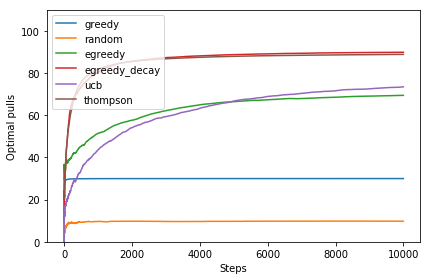

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111)
for st in ["greedy","random","egreedy","egreedy_decay","ucb","thompson"]:

	best_arm_counts = np.zeros((number_of_bandits,number_of_pulls))

	for i in range(number_of_bandits):
		arm_means = np.random.rand(number_of_arms)
		best_arm = np.argmax(arm_means)

		q_values = np.zeros(number_of_arms)
		counts = np.zeros(number_of_arms)
		success=np.zeros(number_of_arms)
		failure=np.zeros(number_of_arms)

		for j in range(number_of_pulls):
			a = pick_arm(q_values,counts,st,success,failure)

			reward = np.random.binomial(1,arm_means[a])
			counts[a]+=1.0
			q_values[a]+= (reward-q_values[a])/counts[a]

			success[a]+=reward
			failure[a]+=(1-reward)
			best_arm_counts[i][j] = counts[best_arm]*100.0/(j+1)
		epsilon=0.3


	ys = np.mean(best_arm_counts,axis=0)
	xs = range(len(ys))
	ax.plot(xs, ys,label = st)

plt.xlabel('Steps')
plt.ylabel('Optimal pulls')

plt.tight_layout()
plt.legend()
plt.ylim((0,110))
plt.show() 

### 冷启动问题

* 本质：推荐系统以来历史数据，但是没有历史数据，无法预测用户的偏好

* 冷启动分类：
    * 用户冷启动，如何给新用户做个性化推荐
    * 物品冷启动，如何将新商品推荐给用户
    * 系统冷启动，用户冷启动+商户冷启动（感觉这种问题好解决，公司都有历史数据）
    
* 用户冷启动问题解决方案：
    * 1.收集用户特征信息
    * 2.制造粗粒度选项，引导用户填写兴趣
    * 3.使用第三方数据
    * 4.新老用户推荐策略差异化
        * 新用户冷启动阶段倾向去推荐热榜，老用户更倾向于长尾推荐
        * 推荐候选的代表性&多样性 ？
        * Explore Exploit力度 ？
        * 使用单独的模型和特征预估
        * 保护用户体验
        
* 物品的冷启动解决方案：
    * ?

### 推荐系统架构

分别介绍：Netflix(2013),Taobao(2015),YouTube(2016)系统结构

* Netflix
    * 离线（offline）:可能一天一更
    * 近乎在线（nearline）：可能一小时一更
    * 在线（online）：实时更新，算法会轻量级一些，比如：LR

* Taobao: 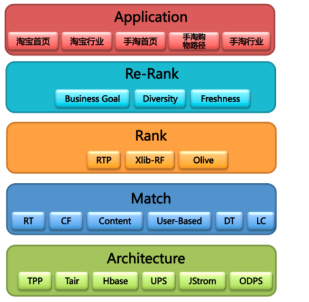

* YouTube : 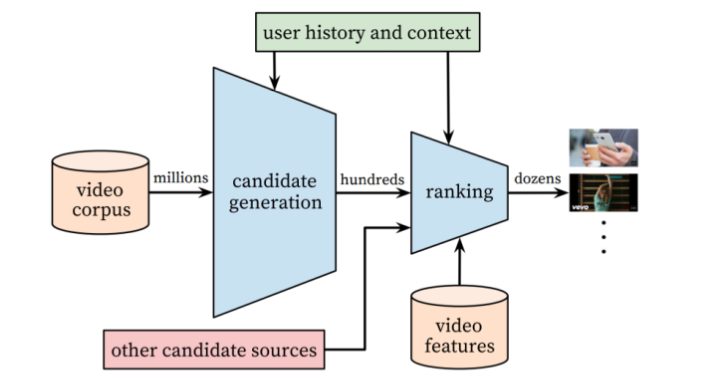